This notebook has regression models to predict number of transactions given the timestamp.

The data is based on an hourly basis (for accuracy issues)

# Deposit

Import libraries

In [126]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

Get the dataset

In [127]:
deposit_raw = pd.read_csv("deposit2019.csv")
successfulVends_raw = pd.read_csv("successfulVENDS2019.csv")

Retrieve columns and rename columns

In [128]:
deposit = deposit_raw[["systemtranstime","transamount"]]
successfulVends = successfulVends_raw[["time","amount"]]
deposit= deposit.rename(index=str,columns={"transamount":"amount","systemtranstime":"time"})

Convert time to datetime

In [129]:
deposit['time']=pd.to_datetime(deposit.time)
successfulVends['time']=pd.to_datetime(successfulVends.time)

Normalization function

In [130]:
def normalize(z):
    x = z
    x = x.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(np.vstack(x))
    return x_scaled

Get number of transactions hourly

In [131]:
deposit_hour = deposit.resample('60min', on='time').count().drop('time',axis=1)

successfulVends_hour = successfulVends.resample('60min', on='time').count().drop('time',axis=1)

In [132]:
#deposit_hour = deposit

Normalize the number of transactions

In [133]:
deposit_hour['amount']=normalize(deposit_hour['amount'])
successfulVends_hour['amount']=normalize(successfulVends_hour['amount'])

Create model

Get the train and test dataset
train: is the first 2 months
test: is the third month

In [134]:
train = deposit_hour[deposit_hour.index.month<3]
test = deposit_hour[deposit_hour.index.month==3]

## STL Decomposition

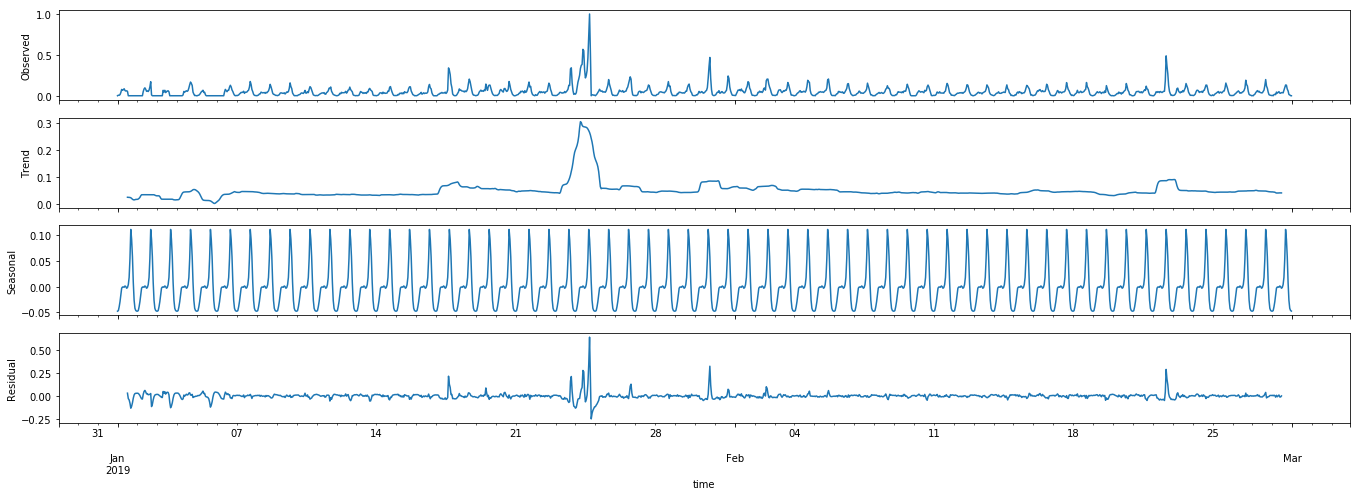

In [135]:
plt.rcParams['figure.figsize']=[19,7]
res = seasonal_decompose(train,model='additive')
resplot = res.plot()

It captures the seasonality.

Renaming column to be able to pass to fb prophet's algorithm

In [136]:
df = deposit_hour.reset_index().rename(index=str,columns={"amount":"y","time":"ds"})
train_fb = df[df.ds.dt.month<3]
test_fb = df[df.ds.dt.month==3]

Create instance of prophet and fit data 

In [137]:
m = Prophet()
m.fit(train_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Predict up to the following month even after two months passed

In [138]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
1441,2019-03-26 23:00:00
1442,2019-03-27 23:00:00
1443,2019-03-28 23:00:00
1444,2019-03-29 23:00:00
1445,2019-03-30 23:00:00


Make predictions

In [139]:
forecast = m.predict(future)

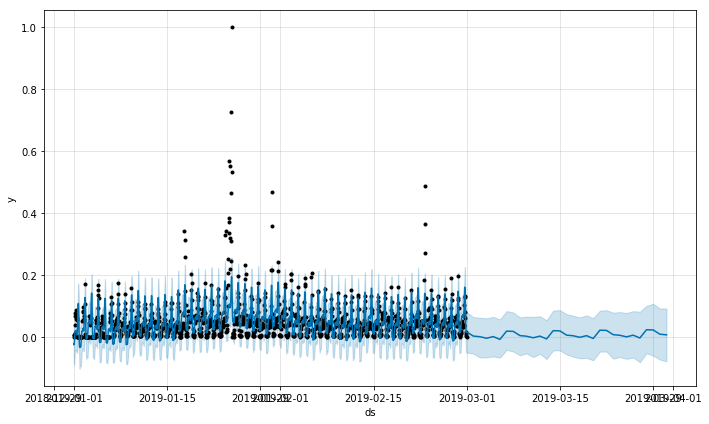

In [140]:
fig1 = m.plot(forecast)

### Classification Trees

Breakdown timestamp to other features so as to pass it to regressors i.e hour,day and day of the week

In [141]:
deposit_hour['hour'] = deposit_hour.index.hour
deposit_hour['day'] =  deposit_hour.index.day
deposit_hour['day_of_week'] =  deposit_hour.index.dayofweek

Create a train and test dataset of the decomposed timestamp dataframe

In [142]:
train_decompose = deposit_hour[deposit_hour.index.month<3]
test_decompose = deposit_hour[deposit_hour.index.month==3]

Create train and test matrices without y column to pass to regression models

In [143]:
X_train = train_decompose.drop(columns=['amount']) 
X_test = test_decompose.drop(columns=['amount']) 

y_train = train_decompose.amount
y_test = test_decompose.amount

Import libraries for the model

In [144]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
 
#these are the hyperparameters that yielded the best test results (no grid search)
clf = RandomForestRegressor(max_depth=8, random_state=6,n_estimators=20)
clf.fit(X_train, y_train) 

y_ = clf.predict(X_test)
y_pred = clf.predict(X_train)

#get r_score
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.86806730414 			 0.431742396919


Creating dataframe to plot predictions and actual with ease

In [145]:
#using test
predictions= test
predictions['predictions'] = y_

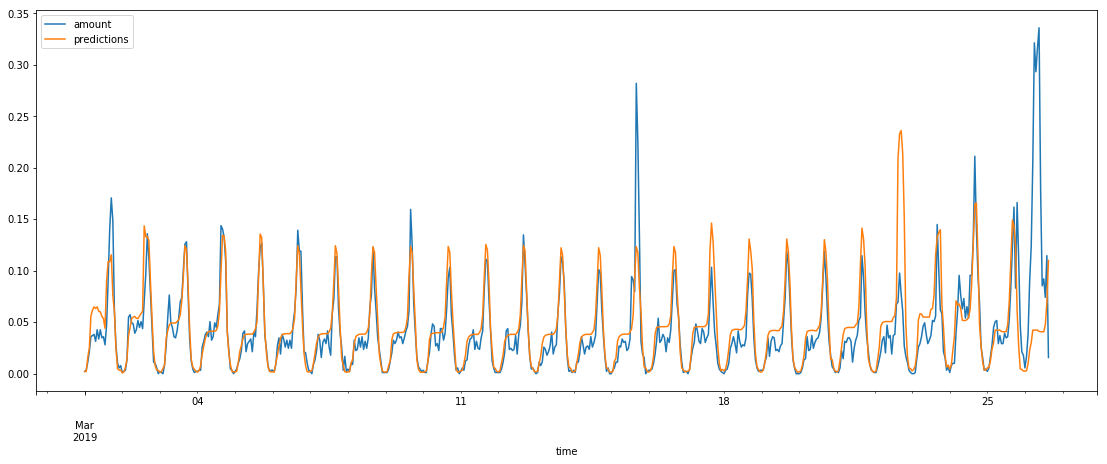

In [146]:
predictions.plot()

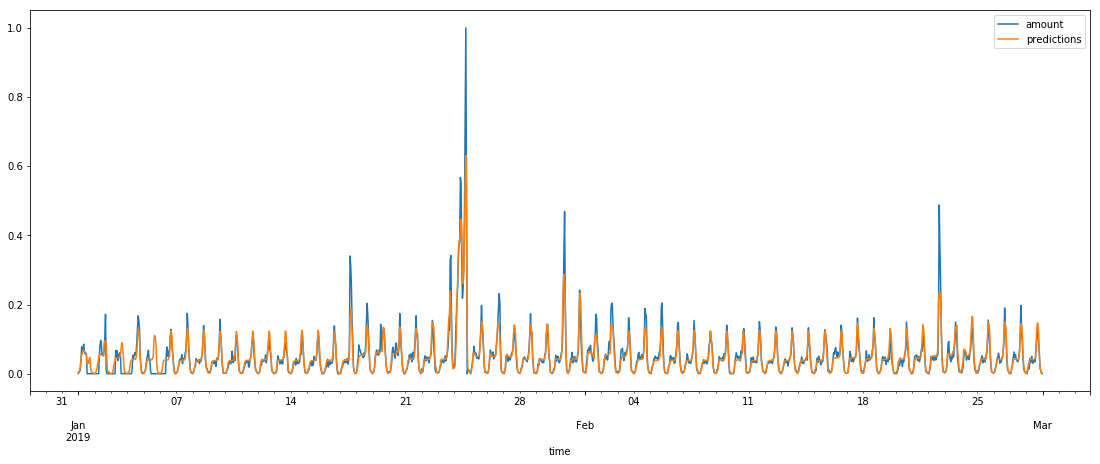

In [147]:
#using train
pred= train
pred['predictions'] = y_pred
pred.plot()

## KNN Regressor


In [148]:
from sklearn.neighbors import KNeighborsRegressor

#number of neighbours with best results (no grid search)
neigh = KNeighborsRegressor(n_neighbors=25)
neigh.fit(X_train, y_train) 
    
y_ = neigh.predict(X_test)
y_pred = neigh.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.530122695002 			 0.393328275195


## Linear Regression

In [149]:
from sklearn.linear_model import LinearRegression

#no tuning of hyperparameters
reg = LinearRegression().fit(X_train, y_train)
y_ = reg.predict(X_test)
y_pred = reg.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.046753978831 			 0.0128477502928


## Stack Regressor

In [150]:
#Ensemble(stacking) for regressors (not sure how it works)
from mlxtend.regressor import StackingRegressor

#use the three algorithms
lr = LinearRegression()
rfr = RandomForestRegressor(max_depth=8, random_state=6,n_estimators=20)

neigh = KNeighborsRegressor(n_neighbors=25)
stregr = StackingRegressor(regressors=[rfr, lr, neigh], 
                           meta_regressor=neigh)

# Training the stacking classifier

stregr.fit(X_train, y_train) 

y_ = stregr.predict(X_test)
y_pred = stregr.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))


0.807633785473 			 0.428673662567
